In [1]:
import sys
import os

project_root = os.path.abspath("..")  # If notebooks is one folder above src
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import torch
from matplotlib import pyplot as plt
from src.eigensolver.kernel.kernel_eigensolver import KernelSolver
from src.energy.quadratic import QuadraticEnergy

In [193]:
dim = 20
sigma = 1.0

kernel_params = {
    'dim': dim,
    'scale': 1.5
}

solver_params = {
    'kernel_name': 'gaussian_kernel',
    'kernel_params': kernel_params,
    'regularizer': 0
}

fit_params = {
    'p': 1000,
    #'xp': torch.linspace(0,5,15).unsqueeze(1)
}

In [194]:
torch.manual_seed(42)
energy = QuadraticEnergy(torch.eye(dim))
solver = KernelSolver(energy, sigma, solver_params)
x = energy.exact_sample((10000,))

In [195]:
solver.fit(x,fit_params)

Orthogonality error: 0.00048340551438741386
L error: 0.00446283770725131


In [196]:
solver.eigvals

tensor([2.1436e-04, 1.0351e+00, 2.0746e+00, 3.7695e+00, 4.3863e+00])

In [39]:
solver.kernel.forward(x,solver.xp).shape

torch.Size([10000, 100])

In [32]:
for i in range(1,x.shape[1]):
    x[:,i] = 0

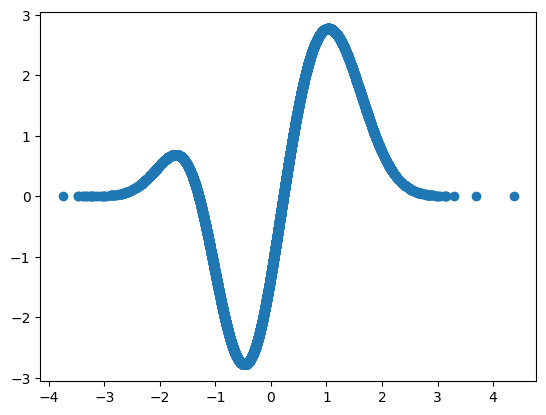

In [34]:
plt.scatter(x[:,0],solver.predict(x)[:,0])

In [51]:
xp = solver.xp

In [52]:
L = solver.compute_L(x,xp)
phi = solver.compute_phi(x,xp)

In [57]:
torch.linalg.eigvals(phi+1e-2*torch.eye(dim))

tensor([ 4.1034e+04+0.0000j,  1.0945e+04+0.0000j,  2.8012e+03+0.0000j,
         6.5249e+02+0.0000j,  1.2814e+02+0.0000j,  2.1291e+01+0.0000j,
         2.9330e+00+0.0000j,  3.3571e-01+0.0000j,  3.2753e-02+0.0000j,
         2.7170e-03+0.0000j, -1.0703e-03+0.0000j,  6.5907e-04+0.0003j,
         6.5907e-04-0.0003j, -3.0745e-04+0.0000j, -2.7343e-04+0.0000j,
         3.7639e-04+0.0000j,  1.8769e-04+0.0002j,  1.8769e-04-0.0002j,
         7.5056e-08+0.0000j,  8.1331e-05+0.0000j])

In [15]:
eigvecs, eigvals = solver.eigvecs, solver.eigvals

In [16]:
grad_k = solver.kernel.grad(xp,x)

# (n, p, p)
first_term = torch.sum(torch.bmm(grad_k, grad_k.transpose(1,2)),dim=0)

# (n, d)
energy_grad = solver.energy.grad(x)

In [24]:
energy_dotprod = torch.bmm(grad_k, energy_grad.unsqueeze(2)).squeeze(2)
k = solver.kernel.forward(x,xp)
second_term = torch.sum(k[:,:,None]*energy_dotprod[:,None,:],dim=0)

In [103]:
second_term.T - second_term

tensor([[   0.0000,   48.8591,   -5.7921,   -9.8925,   -8.2278,  -92.4008,
          -90.1526,   -2.5718,   97.4750,  -23.1839],
        [ -48.8591,    0.0000,  -26.1360,  -27.5527,  -30.9402, -118.8803,
         -127.2057,  -22.7998,   68.0501,  -61.4549],
        [   5.7921,   26.1360,    0.0000,   -2.0998,   -7.1935,  -81.4585,
          -58.0583,    7.4866,   37.9326,  -11.3150],
        [   9.8925,   27.5527,    2.0998,    0.0000,   -1.6142,  -65.7707,
          -51.4215,    7.9088,   47.6292,  -11.2236],
        [   8.2278,   30.9402,    7.1935,    1.6142,    0.0000,  -82.3248,
          -59.4670,   14.3598,   42.1668,  -10.2444],
        [  92.4008,  118.8803,   81.4585,   65.7707,   82.3248,    0.0000,
           10.3239,   84.8817,  128.9948,   57.2728],
        [  90.1526,  127.2057,   58.0583,   51.4215,   59.4670,  -10.3239,
            0.0000,   60.5820,  157.5241,   58.4717],
        [   2.5718,   22.7998,   -7.4866,   -7.9088,  -14.3598,  -84.8817,
          -60.5820,   

In [62]:
L = first_term*solver.sigma + second_term

In [72]:
L = L + L.T

In [24]:
eigenvals, eigenvecs = torch.linalg.eigh(L)

In [25]:
solver.eigvecs

tensor([[ 4.4577e-01,  3.9845e-02, -1.3722e-01,  5.1583e+00, -5.2840e+00,
          8.6350e-02, -2.1631e-01,  1.1812e+00, -9.6693e-01, -4.0157e-01],
        [-4.8838e-01, -2.5503e+00,  3.5316e-02,  7.3451e+00, -7.9788e+00,
          8.3810e-02,  1.2871e-01,  4.8333e+00, -4.2275e+00,  2.8598e+00],
        [-1.0125e+00, -1.2019e+01, -5.1263e-03, -1.5930e+00,  1.7173e+00,
          5.6623e-01,  6.6992e-02, -6.3777e-01,  5.0182e-01,  1.2409e+01],
        [-1.0275e+00,  3.6578e-02, -2.9494e-02,  1.1613e+00, -1.0789e+00,
         -6.4464e-01,  1.3911e-01, -2.1642e+00,  2.1574e+00,  1.4369e+00],
        [-4.5517e-01,  3.3065e-01, -1.6001e-03, -3.3848e+00,  3.3230e+00,
         -8.0924e-02,  5.9207e-02,  3.4689e+00, -3.4672e+00,  1.8145e-01],
        [ 5.6262e-01,  7.7666e-02,  6.8910e-02, -2.9615e+00,  2.7963e+00,
         -3.3992e-01, -2.3813e-01,  6.7568e-01, -5.1180e-01, -1.2899e-01],
        [-3.0598e-01,  5.2728e-02,  1.4180e-01, -5.4444e+00,  5.2256e+00,
          7.7872e-02,  1.5837e-0

In [27]:
L@eigenvecs[0,:]/eigenvecs[0,:]

tensor([ 7.3680e+02, -7.7096e+03, -4.1425e+00,  5.5353e+02, -1.8538e+03,
         1.2779e+03,  1.2776e+03, -5.7439e+03,  1.2387e+03, -1.4421e+03])

In [75]:
eigenvecs@eigenvecs.T

tensor([[ 1.0000e+00, -1.1921e-07, -2.9802e-08,  0.0000e+00, -6.3330e-08],
        [-1.1921e-07,  1.0000e+00,  5.9605e-08,  8.9407e-08,  2.5332e-07],
        [-2.9802e-08,  5.9605e-08,  1.0000e+00,  0.0000e+00,  3.7253e-08],
        [ 0.0000e+00,  8.9407e-08,  0.0000e+00,  1.0000e+00, -1.1921e-07],
        [-6.3330e-08,  2.5332e-07,  3.7253e-08, -1.1921e-07,  1.0000e+00]])

In [119]:
L - eigenvecs@torch.diag(eigenvals)@eigenvecs.T

tensor([[ 6.1035e-04, -4.8828e-04,  1.5259e-04,  1.8311e-04,  0.0000e+00,
         -2.4414e-04, -2.4414e-04,  1.2207e-04, -3.0518e-04, -1.8311e-04],
        [-3.6621e-04, -8.5449e-04, -1.3733e-04, -1.5259e-05, -3.6621e-04,
         -4.8828e-04, -2.4414e-04,  1.5259e-04, -3.6621e-04, -5.4932e-04],
        [ 1.5259e-04, -1.0681e-04,  0.0000e+00, -3.6621e-04, -3.6621e-04,
         -2.4414e-04, -1.2207e-04, -4.8828e-04,  1.8311e-04,  0.0000e+00],
        [ 2.1362e-04, -4.5776e-05, -3.0518e-04, -4.8828e-04, -3.0518e-04,
         -2.4414e-04, -1.2207e-04, -3.6621e-04,  1.0681e-04, -1.8311e-04],
        [ 0.0000e+00, -3.9673e-04, -3.6621e-04, -3.0518e-04, -4.8828e-04,
         -3.6621e-04, -3.0518e-04, -3.6621e-04,  0.0000e+00, -2.1362e-04],
        [-2.4414e-04, -4.8828e-04, -2.4414e-04, -1.8311e-04, -3.6621e-04,
         -3.6621e-04, -3.6621e-04, -1.8311e-04, -1.8311e-04, -3.6621e-04],
        [-2.4414e-04, -3.6621e-04, -1.2207e-04, -2.4414e-04, -3.0518e-04,
         -3.6621e-04, -2.4414e-0